In [1]:
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import numpy as np

class Corridor(object):
    def __init__(self, num_states=19, p=.5, reward_mag=1, start_left=True):
        self.p = p
        self.reward_mag = reward_mag
        self.num_states = num_states
        self.state_shape = [num_states]
        self.nb_actions = 2
        self.state = np.zeros(num_states, dtype='float32')
        self.start_pos = 0 if start_left else int(num_states / 2)
        self.pos = self.start_pos
        self.counter = 0

    def observe(self):
        return np.copy(self.state)

    def _is_over(self):
        # exit or max number of steps
        return self.pos == self.num_states or self.pos == -1 # self.pos == -1 or 

    def _update_state(self, action):
        self.state = np.zeros(self.num_states, dtype='float32')
        if action == 0 and self.pos == 0:
            self.pos -= 1
        elif action == 1 and self.pos == self.num_states - 1:
            self.state = np.zeros(self.num_states, dtype='float32')
            self.pos += 1
        elif action == 0:  # move left
            self.state = np.zeros(self.num_states, dtype='float32')
            self.state[self.pos - 1] = 1
            self.pos -= 1
        elif action == 1:  # move right
            self.state = np.zeros(self.num_states, dtype='float32')
            self.state[self.pos + 1] = 1
            self.pos += 1

    def _get_reward(self):
        flip = np.random.binomial(n=1, p=self.p)
        if flip:
            return self.reward_mag
        else:
            return 0

    def act(self, action):
        assert action == 0 or action == 1 or action == 2
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        self.counter += 1
        # #
        return np.copy(self.state), reward, game_over

    def reset(self):
        self.state = np.zeros(self.num_states, dtype='float32')
        self.state[self.start_pos] = 1
        self.pos = self.start_pos
        self.counter = 0

In [9]:
import numpy as np


class CombinedAgent(object):
    def __init__(self, **kwargs):
        self.v_gamma_0 = Agent(**kwargs, gamma=0, sample_mean_lr=True)
        self.v = Agent(**kwargs)
        
    def predict(self, phi):
        return self.v.predict(phi)
    
    def learn(self, s, a, r, s2, t):
        self.v_gamma_0.learn(s, a, r, s2, t)
        r = self.v_gamma_0.predict(s)
        self.v.learn(s, a, r, s2, t)
        
    def get_values(self):
        return np.round(self.v.theta, 2)
        

class Agent(object):
    def __init__(self, state_shape, nb_actions, gamma=1.0, 
                 lr=0.1, init=0, sample_mean_lr=False):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.gamma = gamma
        self.lr = lr if not sample_mean_lr else np.ones(self.state_shape)
        self.counts = np.ones(self.state_shape)
        self.init = init
        self.theta = np.ones(self.state_shape) * init

    def predict(self, phi):
        return np.dot(self.theta, phi)

    def learn(self, s, a, r, s2, t):
        pred = self.predict(s)
        target = r + (1 - t) * self.gamma * self.predict(s2)
        td = target - pred
        self.theta += self.lr * (td) * s
        self.counts += s
        if type(self.lr) is not float:
            self.lr = np.ones(self.state_shape) / self.counts 
        return td
    
    def reset(self):
        self.theta = np.ones(self.state_shape) * self.init
        
    def get_values(self):
        return np.round(self.theta, 2)

In [14]:
import numpy
import pickle

corridor_len = 5
reward_mags = [1, 2, 5]
p = 0.5
alphas = [0.025, 0.05, 0.075, 0.25, 0.5, 0.75, 1.0]
num_runs = 50

nb_eps = [100]
nb_episodes = max(nb_eps)

all_agent_ep_error = [np.empty((len(reward_mags), num_runs, len(alphas), 2)) for _ in range(len(nb_eps))]

def do_episode(env, agent, learn=True):
    env.reset()
    terminal = False
    squared_error = []
    while not terminal:
        s = env.observe()
        pred = agent.predict(s)
        s2, r, terminal = env.act(1)
        if learn:
            agent.learn(s, a, r, s2, terminal)
    return np.mean(squared_error) ** (1 / 2)


for run in range(num_runs):
    for r, r_mag in enumerate(reward_mags):
        env = Corridor(num_states=corridor_len, p=p, reward_mag=r_mag)
        correct_values = [(i + 1) * p * r_mag for i in range(corridor_len)][::-1]
        for a, alpha in enumerate(alphas):
            for i, cur_agent in enumerate([Agent, CombinedAgent]):
                agent = cur_agent(state_shape=env.state_shape, 
                                  nb_actions=env.nb_actions, 
                                  lr=alpha)
                cumul_error = 0
                for ep in range(1, nb_episodes + 1):
                    do_episode(env, agent, learn=True)
                    cumul_error += np.mean((agent.get_values() - correct_values) ** 2) ** (1/2)
                    if ep in nb_eps:
                        all_agent_ep_error[nb_eps.index(ep)][r, run, a, i] = cumul_error / ep

with open('ep_errors_' + str(corridor_len), 'wb') as f:
    pickle.dump(all_agent_ep_error, f)



/Users/jromoff/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jromoff/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/jromoff/anaconda3/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


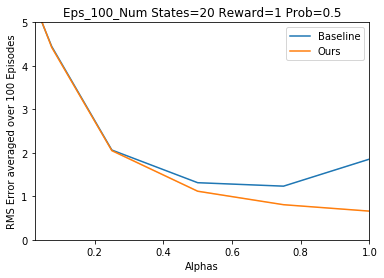

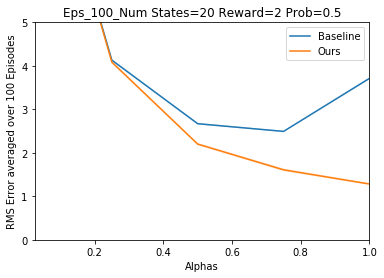

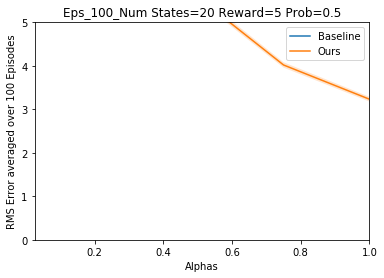

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pickle
from matplotlib.backends.backend_pdf import PdfPages

reward_mags = [1, 2, 5]
with open('ep_errors_' + str(corridor_len), 'rb') as f:
    all_agent_ep_error = pickle.load(f)
    

for r, r_mag in enumerate(reward_mags):
    fig = plt.figure()
    plot = seaborn.tsplot(data=all_agent_ep_error[0][r], time=alphas, 
                          legend=True, condition=['Baseline', 'Ours'])
    plt.ylim(0, 5)
    plot.set_ylabel("RMS Error averaged over " + str(100) + " Episodes")
    plot.set_xlabel("Alphas")
    plot.set_title("Eps_" + str(100) + "_Num States=" +str(corridor_len) + " Reward=" + str(r_mag) + " Prob=" + str(p))
    plt.savefig("Eps_" + str(100) + "_Num States=_" +str(corridor_len) + "_Reward=" + str(r_mag) + "_Prob=" + str(p) + '.pdf',
               bbox_inches='tight')
